# Group: 27
### Submission: 02
### Devs:
    Vivek Verma: Q1, 2
    Harshil Sumra: Q3, 4
    Christian Chihababo: Q5-10
<hr>

#### Following are the paramters used for the compute question below:
|Symbol|Description|Value|
|-|-|-|
|T|Option Maturity|1.0|
|S_0|Current Stock Price|100.0|
|K|Strike Price - At-the-money|100.0|
|sigma|Volatility|0.30|
|r|Risk-free rate|0.08|
|v_0|v0|0.06|
|kappa|Kappa|9|
|theta|Theta|0.06|
|rho|Rho|-0.40|




In [1]:
import numpy as np
from scipy.stats import uniform, norm, ncx2
import matplotlib.pyplot as plt

## 1. Price a European Vanilla call option with the information provided using simple Fourier pricing technique, assuming that the underlying share follows the Heston Model dynamics

In [2]:
T = 1.0
S_0 = 100.0
K = 100.0
sigma = 0.30
r = 0.08

v0 = 0.06
kappa = 9
theta = 0.06
rho = -0.40

t_max = 30
N = 100

k_log = np.log(K)
a = sigma**2 / 2

In [3]:
def calc_b(u, kappa, rho, sigma):
    """Calculate the value of b using u, kappa, rho and sigma"""
    return kappa - rho * sigma * 1j * u


def calc_c(u):
    """Calculate the value of u"""
    return -(u ** 2 + 1j * u) / 2


def calc_d(u, kappa, rho, sigma):
    """Calculate the value of d using u, kappa, rho, sigma"""
    return np.sqrt(calc_b(u, kappa, rho, sigma) ** 2 - 4 * a * calc_c(u))


def calc_xminus(u, kappa, rho, sigma):
    """Calculate the value of x- using u, kappa, rho, sigma"""
    return (calc_b(u, kappa, rho, sigma) - calc_d(u, kappa, rho, sigma)) / (2 * a)


def calc_xplus(u, kappa, rho, sigma):
    """Calculate the value of x+ using u, kappa, rho, sigma"""
    return (calc_b(u, kappa, rho, sigma) + calc_d(u, kappa, rho, sigma)) / (2 * a)


def calc_g(u, kappa, rho, sigma):
    """Calculate the value of g using u, kappa, rho, sigma"""
    return calc_xminus(u, kappa, rho, sigma) / calc_xplus(u, kappa, rho, sigma)


def calc_C(u, kappa, rho, sigma):
    """Calculate the value of C using u, kappa, rho, sigma"""
    val1 = T * calc_xminus(u, kappa, rho, sigma) - np.log((1 - calc_g(u, kappa, rho, sigma) * np.exp(-T * calc_d(u, kappa, rho, sigma))) / (1 - calc_g(u, kappa, rho, sigma))) / a
    return r * T * 1j * u + theta * kappa * val1


def calc_D(u, kappa, rho, sigma):
    """Calculate the value of D using u, kappa, rho, sigma"""
    val1 = 1 - np.exp(-T * calc_d(u, kappa, rho, sigma))
    val2 = 1 - calc_g(u, kappa, rho, sigma) * np.exp(-T * calc_d(u, kappa, rho, sigma))
    return (val1 / val2) * calc_xminus(u, kappa, rho, sigma)


def calc_log_char(u, kappa, rho, sigma, S0):
    """Calculate the value of log_char using u, kappa, rho, sigma and S_0"""
    return np.exp(calc_C(u, kappa, rho, sigma) + calc_D(u, kappa, rho, sigma) * v0 + 1j * u * np.log(S0))


def calc_adj_char(u, kappa, rho, sigma, S0):
    """Calculate the value of adj char using u, kappa, rho, sigma, S_0"""
    return calc_log_char(u - 1j, kappa, rho, sigma, S0) / calc_log_char(-1j, kappa, rho, sigma, S0)


def calc_first_integral(t_n, delta_t, k_log, kappa, rho, sigma, S0):
    """Calculate the value of first integral using t_n, delta_t, k_log, kappa, rho, sigma, S_0"""
    return ((np.exp(-1j * t_n * k_log) * calc_adj_char(t_n, kappa, rho, sigma, S0)).imag / t_n) * delta_t


def calc_second_integral(t_n, delta_t, k_log, kappa, rho, sigma, S0):
    """Calculate the value of second integral using t_n, delta_t, k_log, kappa, rho, sigma, S_0"""
    return ((np.exp(-1j * t_n * k_log) * calc_log_char(t_n, kappa, rho, sigma, S0)).imag / t_n) * delta_t


def calc_fourier_call_price(S0, r, T, K, t_n, delta_t, k_log, kappa, rho, sigma):
    """Calculate the value of the Call price using Fourier method which follows the Heston Dynamics"""
    first_integral = calc_first_integral(t_n, delta_t, k_log, kappa, rho, sigma, S0)
    first_integral_sum = sum(first_integral)
    second_integral = calc_second_integral(t_n, delta_t, k_log, kappa, rho, sigma, S0)
    second_integral_sum = sum(second_integral)
    return S0 * (1 / 2 + first_integral_sum / np.pi) - np.exp(-r * T) * K * (1 / 2 + second_integral_sum / np.pi), first_integral, second_integral


def plot_fourier_first_second_integral(first_intg, second_intg):
    """Plotting function of the 2 integrals"""
    plt.plot(first_intg, label="1st integral")
    plt.plot(second_intg, label="2nd integral")
    plt.xlabel("t")
    plt.ylabel("Integrand value")
    plt.legend()
    plt.show()

In [4]:
# Computing delta_t bounds
delta_t = t_max / N
from_1_to_N = np.linspace(1, N, N)
t_n = (from_1_to_N - 1 / 2) * delta_t

# Call value compute here
fourier_call_val, first_intg, second_intg = calc_fourier_call_price(S_0, r, T, K, t_n, delta_t, k_log, kappa, rho, sigma)
print(f"The Fourier Call value: {fourier_call_val}")


The Fourier Call value: 13.734895692109063


In [5]:
plot_fourier_first_second_integral(first_intg, second_intg)

## 2. Simulating a Share Price Path using 1k to 50k simulations using CEV Model.

In [6]:
sigma = 0.30
gamma = 0.75
delta_t = 1/12 # (t+1) - t

In [7]:
def calc_sigma_t_t_1(S_t, sigma, gamma):
    """Calculate the value of sigma(t, t+1)"""
    return sigma * S_t**(gamma-1)

def calc_share_price_t_1(S_t, r, T, sigma, gamma, Z, delta_t):
    """Calculate the value of share price at t+1 using price at t"""
    sigma_t_t_1 = calc_sigma_t_t_1(S_t, sigma, gamma)
    return S_t * np.exp((r-.5*sigma_t_t_1**2)*delta_t + sigma_t_t_1*Z*np.sqrt(delta_t))

def calc_share_price_path(S_0, r, T, sigma, gamma, delta_t, cycles=50, base_iteration_steps=1000):
    """Simulate and calculate the entire share price path, using the CEV model"""
    months = int(T * 12)
    share_price_path = [None]*cycles # To store the average of the prices calculated per cycle
    share_price_path_std = [None]*cycles # To store the prices' standard deviation calculated per cycle

    for simulation_cycle in range(1, cycles+1):
        simulation_limit = base_iteration_steps * simulation_cycle  # Calculating the number of sample sizes to use in this cycle
        random_store = norm.rvs(size=[simulation_limit, months]) # Generating the random values with dimensions being simulation_limit x months
        cycle_price_path = np.array([0.0] * simulation_limit) # To store the prices calculated in this cycle

        for iteration in range(0, simulation_limit):
            S_t = S_0 # base set for the iteration
            for month in range(0, months): # iterate over the number of months
                Z = random_store[iteration][month] # pick random number from the random number store generated earlier
                S_t = calc_share_price_t_1(S_t, r, T, sigma, gamma, Z, delta_t) # compute S_t using the parameters
            cycle_price_path[iteration] = S_t # assign final price of S_t => S_T, from end of iteration to the cycle_price_path

        share_price_path[simulation_cycle-1] = np.mean(cycle_price_path)
        share_price_path_std[simulation_cycle-1] = np.std(cycle_price_path) / np.sqrt(simulation_limit)

    return np.mean(share_price_path), share_price_path, share_price_path_std


In [8]:
cycles = 50

from datetime import datetime
dt1 = datetime.now()
# triggering the actual compute for 50 cycles
mean_share_price_path, share_price_path, share_price_path_std = calc_share_price_path(
    S_0=S_0, 
    r=r, 
    T=T, 
    sigma=sigma, 
    gamma=gamma,
    delta_t=delta_t,
    cycles=cycles
)

print(f"Mean Share Price from the paths: $ {mean_share_price_path:.3f}")
delta = datetime.now() - dt1
print(f"Time taken for the compute: {delta}")


Mean Share Price from the paths: $ 108.331
Time taken for the compute: 0:01:58.777967


In [9]:
def plot_share_path_values(share_price_path, cycles, share_price_path_std, 
                            std_degree=3, analytical_plt_color='g', 
                            estimated_plt_style='-', estimated_err_plt_color='r', 
                            xlabel='Sample Size (x1000)', ylabel='Value'):
    """Function to plot the share paths"""
    plt.plot(share_price_path, estimated_plt_style) # Plot the estimated values
    plt.plot(share_price_path + np.array(share_price_path_std) * std_degree, estimated_err_plt_color) # <std-degree> standard deviations around the Mean in error bound
    plt.plot(share_price_path - np.array(share_price_path_std) * std_degree, estimated_err_plt_color) # <std-degree> standard deviations around the Mean in error bound
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

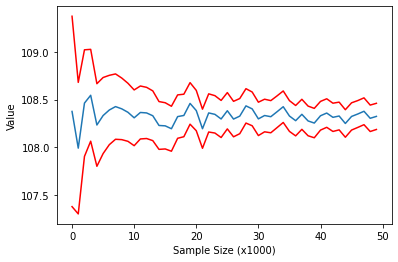

In [10]:
plot_share_path_values(share_price_path, cycles, share_price_path_std)

# 3. Use code in part to to calculate Monte Carlo Estimates and their standard deviations for the price of vanilla call option


In [11]:
#pricing call option based on above model
dt=1/12
gamma=0.75
def call_price_and_stddev(t, N):
    n = int(T/dt)
    Z = norm.rvs(size =[N, n])
    price_path = np.array([[np.float64(S_0)]*(n+1)]*N)
    for i in range(n):
        vol = sigma*price_path[:,i]**(gamma-1)
        power = (r-vol**2/2)*dt+vol*np.sqrt(dt)*Z[:,i]
        price_path[:,i+1]=price_path[:,i]*np.exp(power)
    pay_off = np.maximum(price_path[:,-1]-K, 0)*np.exp(-r*t)
    return np.mean(pay_off), np.std(pay_off)/np.sqrt(N)

In [12]:
#o/p variables
call_price = [None]*50
call_stddev = [None]*50

# price estimates
for i in range(1, 51):
    call_price[i-1], call_stddev[i-1] = call_price_and_stddev(T, i*1000)

In [13]:
# CEV closed form call price
z = 2+1/(1-gamma)
def closed_form_call_price(t):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S_0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S_0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

# 4. Plot the Monte Carlo estimates generated in part 3 with respect to sample size, as well as three standard deviation error bounds around these estimates

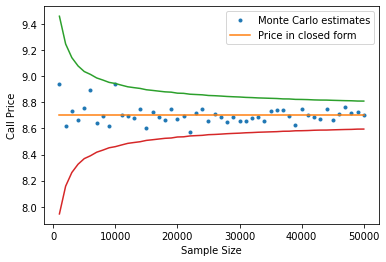

In [14]:
#Ans.4. plot of abobe results
plt.plot(np.array(range(1,51))*1000, call_price, '.', label="Monte Carlo estimates")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)]*50, label="Price in closed form")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)+3*s for s in call_stddev])
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)-3*s for s in call_stddev])
plt.xlabel("Sample Size")
plt.ylabel("Call Price")
plt.legend()
plt.show();

In [15]:
print(f'CEV closed form call option price is {closed_form_call_price(T)}')
print(f'Monte Carlo estimate of call option price is {call_price[-1]}')
print(f'Difference between the two approaches = {round(call_price[-1]-closed_form_call_price(T),3)}')

CEV closed form call option price is 8.702333534327622
Monte Carlo estimate of call option price is 8.701155375484285
Difference between the two approaches = -0.001


## Question 5: Graphing the Volatility Smile

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
from scipy.stats import norm
from scipy.stats import ncx2
import random

In [ ]:
# Package for fetching historical market data from Yahoo Finance API
!pip install yfinance 

In [ ]:
# Fetching Historical 1 year stock price data
import yfinance as fin
data = fin.download('FB','2018-01-01','2019-01-01')['Adj Close']
# Sorting by Date
data.sort_index(ascending=False, inplace=True)
prices = data.reset_index()
prices.columns = ['date','adjClose']

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Daily log returns
prices['returns'] = (np.log(prices.adjClose /
    prices.adjClose.shift(-1)))

# Daily STD of returns
d_std = np.std(prices.returns)

# Annualized daily STD with SIGMA = Standard Deviation
std = d_std * 252 ** 0.5

print("Sigma (Volatility) = ", std)

Sigma (Volatility) =  0.39050002816034096


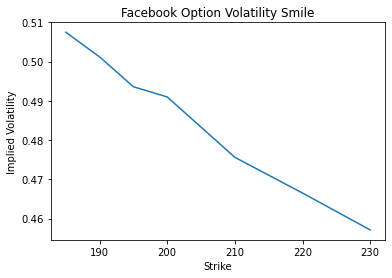

In [ ]:
import datetime
current_date = datetime.datetime(2022, 5, 2)
stock_price = 200.47
option_expiration_date = datetime.datetime(2023, 3, 17)
# Maturity
T_days = option_expiration_date - current_date
T = T_days.days/365 # Time to maturity in years
# K = 200 , implied_volatility = 0.4910, market_price = 35.77
K = 200
sigma = 0
bK_1 = 195
bk_1_implied_volatility = 0.4936
bK_1_market_price = 38.00

bK_2 = 190
bk_2_implied_volatility = 0.5012
bK_2_market_price = 43.30

bK_3 = 185
bk_3_implied_volatility =  0.5075
bK_3_market_price = 46.17

aK_1 = 210
ak_1_implied_volatility = 0.4756
aK_1_market_price = 34.50

aK_2 = 220
ak_2_implied_volatility = 0.4665
aK_2_market_price = 26.88

aK_3 = 230
ak_3_implied_volatility = 0.4571
aK_3_market_price = 25.65

fb_option_strikes = [185, 190, 195, 200, 210, 220, 230]
fb_option_imp_vols = [ 0.5075, 0.5012, 0.4936, 0.4910, 0.4756, 0.4665,0.4571]
pt.title("Facebook Option Volatility Smile")
pt.plot(fb_option_strikes,fb_option_imp_vols)
pt.ylabel("Implied Volatility")
pt.xlabel("Strike")
pt.show()

## Question 6: Function for Computing Implied Volatility

In [ ]:
# Installing library for calculating option prices, implied volatility and greeks
!pip install py_vollib

In [ ]:
from py_vollib.black_scholes import black_scholes as bls
from py_vollib.black_scholes.greeks.analytical import vega

tolerence = 0.00001
option_type = 'c' # Vanilla European Call Option
risk_free_rate = 0.0037 # May 02's U.S. 1 Month Treasury Rate

def implied_vol(S0,K,T,r,market_price, flag = option_type, tol = tolerence):
    """Calculating Implied Volatolity for a Vanilla European Option, using Newton-Raphson Method of root finding
    S0: Stock price
    K: Strike price
    T: Time to maturity
    r: risk free rate
    market_price: Option price in the market
    """
    max_iter = 1000 # Maximum Number of iterations
    vol_old = 0.3 # Initial guess
    for j in range(max_iter):
        bls_price = bls(flag,S0,K,T,r,vol_old)
        Cprime = vega(flag,S0,K,T,r,vol_old)*100
        c = bls_price - market_price
        
        vol_new = vol_old - c/Cprime
        new_bls_price = bls(flag,S0,K,T,r,vol_new)
        if(abs(vol_old - vol_new) < tol or abs(new_bls_price - market_price) < tol):
            break
        
        vol_old = vol_new
    implied_volatility = vol_new
    return implied_volatility


K_1 = bK_1
K_2 = aK_2
market_price_1 = bK_1_market_price
market_price_2 = aK_2_market_price

implied_vol_1 = implied_vol(S0 = stock_price, K = K_1, T = T, r = risk_free_rate, market_price = market_price_1,
                  flag = option_type, tol = tolerence) 

implied_vol_2 = implied_vol(S0 = stock_price, K = K_2, T = T, r = risk_free_rate, market_price = market_price_2,
                  flag = option_type, tol = tolerence) 

strike_levels = [K_1 , K_2]
web_imp_vol = [bk_1_implied_volatility,ak_2_implied_volatility]
cal_imp_vol = [implied_vol_1,implied_vol_2]
import pandas as pd
DF_Implied_Volatilities = pd.DataFrame([[strike_levels[0],web_imp_vol[0],cal_imp_vol[0]],
                                        [strike_levels[1],web_imp_vol[1],cal_imp_vol[1]]],
                                        columns = ["Strike Level", "Implied Volatility from the net",
                                                   "Computed Implied Volatility"])
DF_Implied_Volatilities

Strike Level  Implied Volatility from the net  Computed Implied Volatility
0           195                           0.4936                     0.477498
1           220                           0.4665                     0.457270

## Question 7: Calculating of the Volatility Skew for Facebook 

In [ ]:
# Volatility skewness
delta_y = bk_3_implied_volatility - bk_1_implied_volatility
delta_x = bK_3 - bK_1
v_skew = delta_y/delta_x
print(" FB Volatility Skewness = ", v_skew )

 FB Volatility Skewness =  -0.0013899999999999967


## Question 8: In Black Scholes, does the volatility depend on the strike level? Why or why not?
**ANSWER**

No, it does not and it is so because each asset is assumed to have constant volatility. In other words, in the Black Scholes, volatility is constant despite the maturity and/or the strike level.

## Question 9: How does the Heston Model better estimate the volatility smile? Specifically, what is different in Heston’s model from Black Scholes that allows more estimate option pricing? 

**ANSWER**

Because of its extension of the relaxation of the constant volatility assumption, the Heston model performs better in estimating the volatility smile than the Black Scholes model. The model takes into account a possible correlation between the stock price and its volatility. Also, the Heston Model does not require of the stock prices to follow a lognormal probability distribution but gives a closed-form solution.

## Question 10 (DISCUSSION): How the Heston model better prices the volatility smile than the Black-Scholes model.

**ANSWER**

### Brief Story
Significant contributions to the option pricing theory were made by Economists Fischer Black and Myron Scholes in 1968 while in 1973 Robert C. Merton contributed to continuous-time finance, especially the first continuous-time option pricing model, the Black–Scholes–Merton model. They provided a simple solution for European options by considering a Geometric Brownian Motion for the underlying (Heston, 1993). Later, the Black-Scholes-Merton model was considered insufficient for real life option pricing; therefore, in 1994 Mark Edward Rubinstein rejected the theory stating that the data was a risk-free process.

### Volatility Smile
Regarding volatility smile, a volatility smile curve is a plot of the different strike prices of an option contract along the abscissa axis and the implied volatility given by the Black-Scholes Model (BSM) along the ordinate axis; and as one moves from the option at-the-money to the option at-the-money or out-of-the-money, the implied volatility increases significantly. This character of volatility is observable in the market. By observing the volatility smile, the BSM assumption of constant volatility yields a straight line graph instead of a smile curve, indicating that the BSM assumption of constant volatility is incorrect.

In addition, stochastic models such as the Heston model, the SABR model, and the constant elasticity of variance (CEV) are more appropriate for option pricing since they incorporate changing volatility. In 1987, both Johnson and Shanno conducted a study of stochastic volatility. Their study of stochastic volatility attempted to address the limitations of the Black Scholes by allowing volatility to fluctuate over time.

Since then, Hull and White and Scott and Wiggins have further developed the concept of stochastic volatility and proved that volatility is a random process that fluctuates over time. In 1991, Jeremy C. Stein derived for the first time an analytical solution by assuming that volatility follows a mean-reverting process and is uncorrelated with the underlying asset returns.

In 1993, Steven "Steve" L. Heston introduced a stochastic volatility model in his paper, a model that allows for an arbitrary correlation between volatility and cash asset returns. His model involves two stochastic differential equations: (1) geometric Brownian motion that accounts for the evolution of the asset price, and (2) a Cox–Ingersoll–Ross model that accounts for the evolution of volatility. The Heston model allows the volatility of the underlying asset price to fluctuate as a random variable, and confirms the claims of Stein & Stein.

Also, in letting the price vary, the Heston model gives more accurate computations and forecasts, and also incorporates the volatility smile. While the BSM produces option prices identical to those of stochastic volatility models for at-the-money options, the Heston model allows for a greater implied volatility weighting for downward versus upward strikes.